In [1]:
import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
import datetime
import pickle
import time

import os
import rasterio
import shapely.geometry

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#from sklearn.cluster import dbscan

In [3]:
output_dir = "/home/ubuntu/data/TX_paired/"

In [4]:
#load geo_pandas DataFrame
geo_df = pickle.load( open( output_dir+"GeoDataFrame_fine.pickled", "rb" ))
geo_df['bad_image']=None
geo_df['problem']=None
geo_df['verified']=None
geo_df.set_index("tile_no")
geo_df.head(2)

,tile_no,%flooded,post-storm_full,pre-storm_full,post-storm_resized,pre-storm_resized,course_mask_full,course_mask_resized,fine_make_filename,footprint,dry/wet,mask_poly,tile_transform,geometry,DBScan,bad_image,problem,verified
0,0,0.80323,0_post_resize_img,0_pre_resize_img,0_post_full_img,0_pre_full_img,0_mask,0_resize_mask,0_256_fine_mask,3002220.tif,wet,(POLYGON ((-95.57181511210993 29.4410615808823...,"[222822.4, 0.0, 0.0, -222822.4, 21295616.0, 65...",POLYGON ((-95.56985294117646 29.44106158088235...,0_256_DBSCAN,None,None,None
1,1,0.8787,1_post_resize_img,1_pre_resize_img,1_post_full_img,1_pre_full_img,1_mask,1_resize_mask,1_256_fine_mask,3002220.tif,wet,POLYGON ((-95.56764981800494 29.44136752727207...,"[222822.4, 0.0, 0.0, -222822.4, 21295104.0, 65...",POLYGON ((-95.56755514705883 29.44106158088235...,1_256_DBSCAN,None,None,None


In [5]:
#fix some formatting problems and typos
#note: full and resized images are backwards
geo_df.rename(columns = {'%flooded':'flooded','dry/wet':'dry_or_wet','fine_make_filename':'fine_mask_filename'}, inplace=True)
geo_df.head(1)

,tile_no,flooded,post-storm_full,pre-storm_full,post-storm_resized,pre-storm_resized,course_mask_full,course_mask_resized,fine_mask_filename,footprint,dry_or_wet,mask_poly,tile_transform,geometry,DBScan,bad_image,problem,verified
0,0,0.80323,0_post_resize_img,0_pre_resize_img,0_post_full_img,0_pre_full_img,0_mask,0_resize_mask,0_256_fine_mask,3002220.tif,wet,(POLYGON ((-95.57181511210993 29.4410615808823...,"[222822.4, 0.0, 0.0, -222822.4, 21295616.0, 65...",POLYGON ((-95.56985294117646 29.44106158088235...,0_256_DBSCAN,None,None,None


In [6]:
#get tile_no for those tiles with more than a little flooding
t = geo_df["flooded"] >= 0.00
sum(t)
tiles = geo_df[t].tile_no

In [7]:
tiles.values

array([0, 1, 2, ..., 4402, 4403, 4404], dtype=object)

In [8]:
#prep sub-function for re-writing masks
def re_write_mask(num,DBScan_mask,tile_no):
    c_id = int(num)
    fine_mask = 1*(DBScan_mask==c_id)
    np.save(output_dir+"%d_256_fine_mask"%tile_no, fine_mask)
    print("re-mask to cluster number %d",c_id)
    return

('working on tile #:', 0)


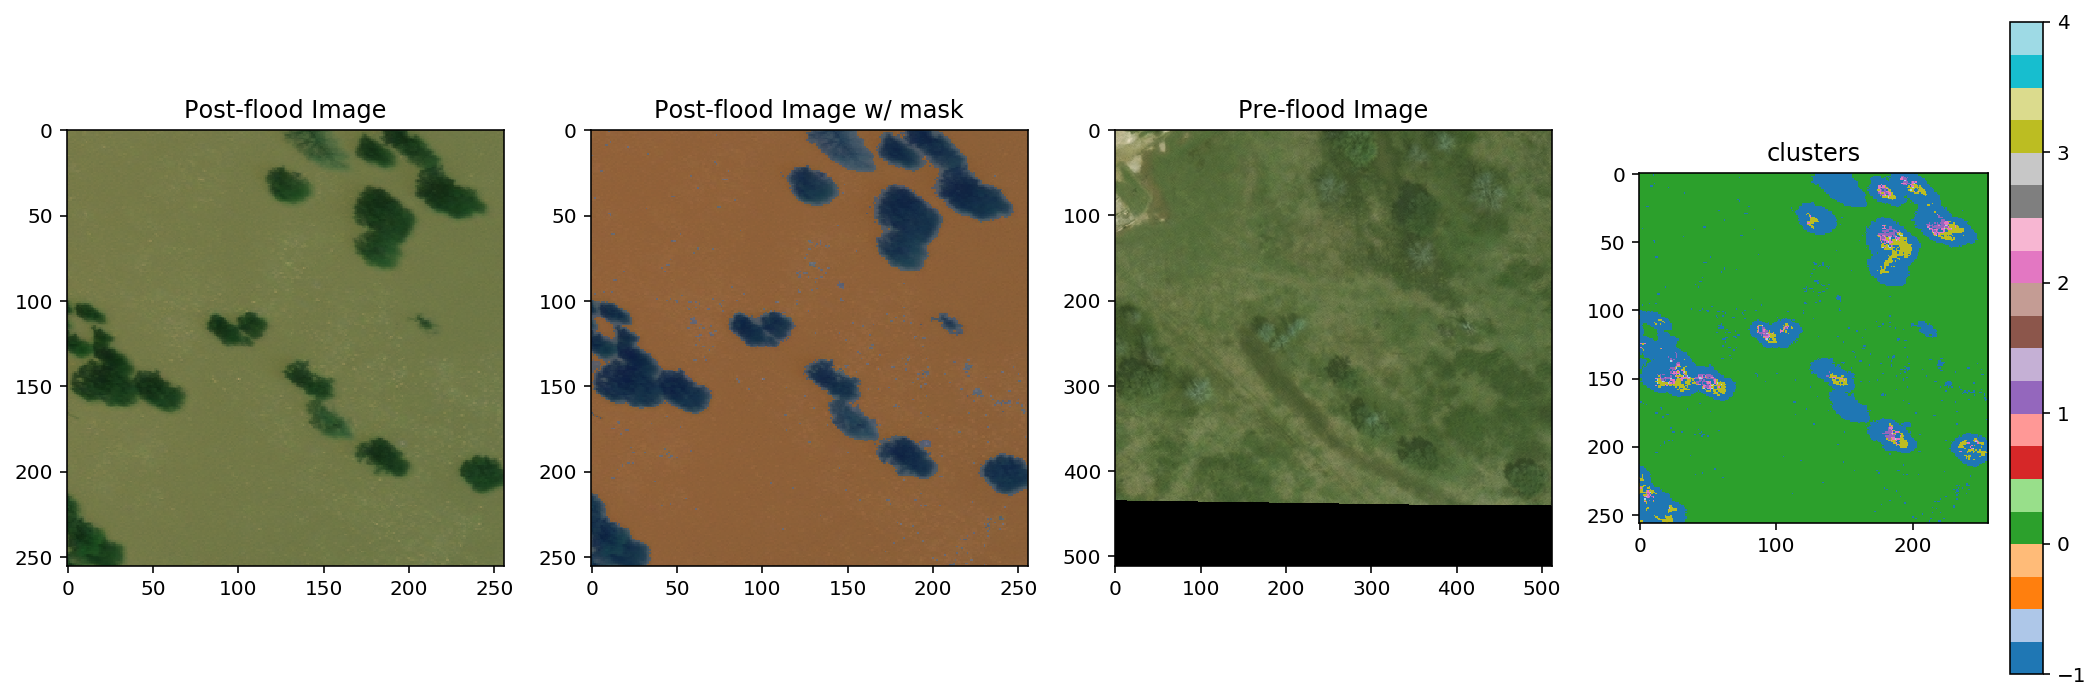

percent D.G. flooding labeled: 0
b
oops
esc
('working on tile #:', 1)


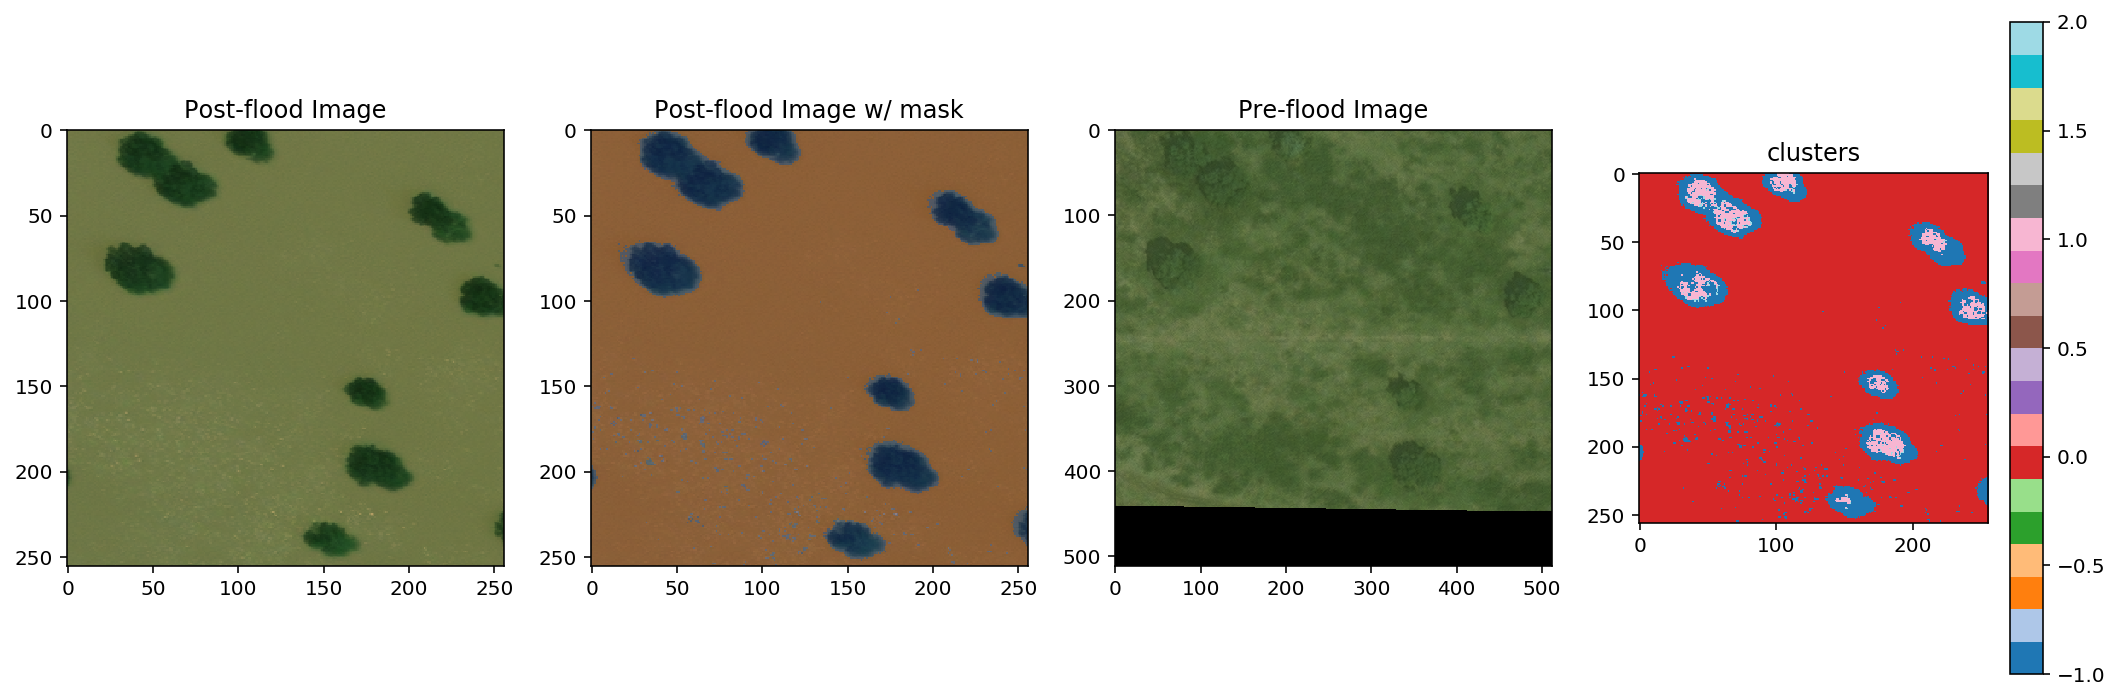

percent D.G. flooding labeled: 0


KeyboardInterrupt: 

In [13]:
#run a subset of data at a time in case DBSCAN kills the kernel
for tile_no in tiles.values[:]:
    print("working on tile #:",tile_no)
    
    #load files
    img_post = np.load(output_dir+'%d_post_resize_img.npy'%tile_no)
    img_pre  = np.load(output_dir+'%d_pre_full_img.npy'%tile_no)
    #mask = np.load(output_dir+'%d_resize_mask.npy'%tile_no)
    fine_mask = np.load(output_dir+'%d_256_fine_mask.npy'%tile_no)
    #DBScan cluster map
    DBScan_mask = np.load(output_dir+'%d_256_DBSCAN.npy'%tile_no)
        
    #plot for inspection and approval/adjustment/rejection
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(18,6))
    ax1.set_title("Post-flood Image")
    ax2.set_title("Post-flood Image w/ mask")
    ax3.set_title("Pre-flood Image")
    ax4.set_title("clusters")
    ax1.imshow(img_post)
    ax2.imshow(img_post)
    ax2.imshow(fine_mask,cmap='bwr',alpha = 0.2)
    ax3.imshow(img_pre)
    plt.imshow(DBScan_mask,cmap='tab20')
    plt.colorbar()
    plt.show();
    print("percent D.G. flooding labeled: %d"%geo_df.flooded[tile_no])
    
    #prep blank mask
    blank_mask = np.zeros(img_post.shape[0:2],dtype='int64')
    
    #wait while plots show, then prompt user for what to do with the image/mask
    time.sleep(0.1)
    
    bad_input = True
    while bad_input == True:
        bad_input = False
        a = raw_input()
        a = str(a)
    
        if   a == 'g': print("tile_no %d approved!"%tile_no)
            
        elif a == 'b': #treat file as bad
            probtext = str(raw_input())
            if probtext == "oops":
                bad_input=True
                continue
            geo_df.bad_image[tile_no] = True
            geo_df.problem[tile_no] = str(probtext)
            
        elif a == 'd': #treat guess as dry, and write blank mask
            geo_df.dry_or_wet[tile_no] = 'dry'
            np.save(output_dir+"%d_256_fine_mask"%tile_no, blank_mask)
            
        elif a == 'skip': break
            
        elif a == '0': #set mask cluster to 'n' and re-write mask,  same for 1,2,3,4,5,6...
            re_write_mask(a,DBScan_mask,tile_no)
        elif a == '1': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '2': re_write_mask(a,DBScan_mask,tile_no)    
        elif a == '3': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '4': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '5': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '6': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '7': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '8': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '9': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '10': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '11': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '12': re_write_mask(a,DBScan_mask,tile_no)    
        elif a == '13': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '14': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '15': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '16': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '17': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '18': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '19': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '20': re_write_mask(a,DBScan_mask,tile_no)
            
        else: 
            bad_input = True
            print("bad entry, try again: g=good, d=dry, 'skip'=skip image, b=bad ('oops' to cancel), and make note, number --20 for cluster")
    
    #mark file is visually verified (unless skipped)
    if a != 'esc': geo_df.verified[tile_no] = True

    #write geopandas to file too
    geo_df.to_pickle(output_dir+"GeoDataFrame_fine_turked.pickled")
    

#leftover code snippets

    
    print("floodwater/mud at id:",c_id)
    if dry == True: fine_mask = np.zeros((side,side),dtype='int64')  #the mask data type should match
    else: fine_mask = 1*(DBScan_mask==c_id)
    
    
    if dry == True: fine_mask = np.zeros((side,side),dtype='int64')  #the mask data type should match
    else: fine_mask = 1*(DBScan_mask==c_id)
    np.save(output_dir+"%d_256_fine_mask"%tile_no, fine_mask)

# plotting routines

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.set_title("Flood Water Only")
ax2.set_title("Flood Water removed")
ax1.imshow(img_post*(np.expand_dims(DBScan_mask==c_id,axis=2)) )
ax2.imshow(img_post*(np.expand_dims(DBScan_mask!=c_id,axis=2)));

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.set_title("difference image")
ax2.set_title("New Image Mask(Label)")
ax3.set_title("DigitalGlobe MDA Shapefile label")
ax1.imshow(img_diff)
ax2.imshow(255.*(DBScan_mask==c_id))
ax3.imshow(mask);

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.set_title("Post-flood Image")
ax2.set_title("DBSCAN Clusters")
ax3.set_title("Pre-flood Image")
ax1.imshow(img_post)
ax2.imshow(DBScan_mask)
ax3.imshow(img_pre);

fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(18,6))
ax1.set_title("Post-flood Image")
ax2.set_title("Post-flood Image w/ mask")
ax3.set_title("Pre-flood Image")
ax4.set_title("clusters")
ax1.imshow(img_post)
ax2.imshow(img_post)
ax2.imshow(1-(DBScan_mask==c_id),cmap='bwr',alpha = 0.2)
ax3.imshow(img_pre)
plt.imshow(DBScan_mask)
plt.colorbar();